In [1]:
import torch

import matplotlib.pyplot as plt
import random

import pandas as pd
from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler


from torch.utils.data import random_split
from torch.optim.lr_scheduler import StepLR
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Sigmoid
from torch.nn import Module
from torch.optim import SGD
from torch.nn import BCELoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from numpy import vstack
from numpy import argmax

import torch.nn.functional as F
import torch.nn as nn

import numpy as np

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('CUDA:', torch.cuda.is_available(), ' Use << {} >>'.format(device.upper()))
print('PyTorch Version:', torch.__version__)

CUDA: True  Use << CUDA >>
PyTorch Version: 1.7.1+cu110


In [3]:
class CSVDataset(Dataset):
    def __init__(self, file_name):

        dataframe = pd.read_csv(file_name)
        print("Data looks like")
        x = dataframe.iloc[:,0:9].values
        y = dataframe.iloc[:, 9].values # y is label
        z = dataframe.iloc[:, 10:15].values # z is about the details and not used for the training
        
        self.x = x
        self.y = y
        self.z = z
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx): 
        return self.x[idx], self.y[idx], self.z[idx]

In [4]:
class TrainDataset(Dataset):
    def __init__(self, file_name):

        dataframe = pd.read_csv(file_name)
        
        x = dataframe.iloc[:,0:9].values 
        y = dataframe.iloc[:, 9].values
        y = (y-100)/100
        z = dataframe.iloc[:, 10:15].values
        
        #converting to torch tensors
        self.x = torch.tensor(x, dtype=torch.float32) 
        self.y = torch.tensor(y, dtype=torch.int32)
        self.z = torch.tensor(z, dtype=torch.int32)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx): 
        return self.x[idx], self.y[idx], self.z[idx]

In [5]:
import os
import csv
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

os.chdir("C:\\Users\\widen\\Desktop\\predict_CAM\\MLP\\final")
input_data = CSVDataset('raw_base_labelled_input.csv')


print("\nTotal Data Length:", len(input_data))


X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(input_data.x, input_data.y, input_data.z, test_size=0.3, shuffle = True, random_state=42)
X_val, X_test, y_val, y_test, z_val, z_test = train_test_split(X_test, y_test, z_test, test_size=0.5, shuffle = True, random_state = 3)

print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)
print('X_test shape:', X_test.shape)

print('y_train shape:', y_train.shape)
print('y_val shape:', y_val.shape)
print('y_test shape:', y_test.shape)



torch.set_printoptions(precision=10)

# Save train data set
f = open('2_raw_base_labelled_train_set.csv','w', newline='')
wr = csv.writer(f)

for i in range(len(y_train)):
    wr.writerow([X_train[i][0]/100-5.5, X_train[i][1], X_train[i][2], X_train[i][3], X_train[i][4], X_train[i][5], X_train[i][6], X_train[i][7], X_train[i][8], y_train[i] , z_train[i][0], z_train[i][1], z_train[i][2], z_train[i][3], z_train[i][4]])
    
f.close()

# Save validation data set
f = open('2_raw_base_labelled_val_set.csv','w', newline='')
wr = csv.writer(f)

for i in range(len(y_val)):
    wr.writerow([X_val[i][0]/100-5.5, X_val[i][1], X_val[i][2], X_val[i][3], X_val[i][4], X_val[i][5], X_val[i][6], X_val[i][7], X_val[i][8], y_val[i], z_val[i][0], z_val[i][1], z_val[i][2], z_val[i][3], z_val[i][4]])
    
f.close()



# Save test data set
f = open('2_raw_base_labelled_test_set.csv','w', newline='')
wr = csv.writer(f)

for i in range(len(y_test)):
    wr.writerow([X_test[i][0]/100-5.5, X_test[i][1], X_test[i][2], X_test[i][3], X_test[i][4], X_test[i][5], X_test[i][6], X_test[i][7], X_test[i][8], y_test[i], z_test[i][0], z_test[i][1], z_test[i][2], z_test[i][3], z_test[i][4]])
    
f.close()



Data looks like

Total Data Length: 18261
X_train shape: (12782, 9)
X_val shape: (2739, 9)
X_test shape: (2740, 9)
y_train shape: (12782,)
y_val shape: (2739,)
y_test shape: (2740,)


In [6]:
class MLP(nn.Module):
    def __init__(self, n_input):
        super(MLP, self).__init__()
        
        self.act = ReLU()
        
        self.hidden1 = Linear(n_input, 100).to(device)
        
        self.hidden2 = Linear(100, 300).to(device)
        
        self.hidden3 = Linear(300, 100).to(device)
        
        self.hiddenfinal = Linear(100, 10).to(device)
        
        #self.actfinal = nn.Softmax(dim=0) 
        #self.actfinal = nn.LogSoftmax(dim=0) 

    def forward(self, X):
        
        X = self.hidden1(X)
        X = self.act(X)
        
        X = self.hidden2(X)
        X = self.act(X)
        
        X = self.hidden3(X)
        X = self.act(X)
        
        X = self.hiddenfinal(X)
        
        return X

In [7]:
epoches = 300
batch_size = 40
learning_rate = 0.001

In [8]:
os.chdir("C:\\Users\\widen\\Desktop\\predict_CAM\\MLP\\final")
trainset = TrainDataset('2_raw_base_labelled_train_set.csv')
valset = TrainDataset('2_raw_base_labelled_val_set.csv')
testset = TrainDataset('2_raw_base_labelled_test_set.csv')

trainLoader = torch.utils.data.DataLoader(trainset, batch_size, shuffle = True)
valLoader = torch.utils.data.DataLoader(valset, batch_size, shuffle = True)
testLoader = torch.utils.data.DataLoader(testset, batch_size, shuffle = True)

model = MLP(9)
model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=10, gamma=0.8)
history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[], 'test_loss':[], 'test_acc':[]}

In [9]:
def accuracy_check_for_batch(labels, preds, batch_size):
    total_acc = 0
    for i in range(batch_size):        
        total_acc += accuracy_check(labels[i], preds[i])
    return total_acc/batch_size

In [10]:
def get_loss_train(model, trainloader, criterion, device):
    model.eval()
    total_acc = 0
    total_loss = 0
    
    for batch, (inputs, labels, details) in enumerate(trainLoader):
        with torch.no_grad():
            inputs = inputs.to(device)
            labels = labels.to(device = device, dtype = torch.int64)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            preds = torch.argmax(outputs, dim=1) #
            acc = accuracy_check_for_batch(labels, preds, inputs.size()[0])
            total_acc += acc
            total_loss += loss.cpu().item()
        
    return total_acc/(batch+1), total_loss/(batch+1)

In [11]:
def accuracy_check(label, pred):
    ims = [label, pred]
    np_ims = []
    for item in ims:
        item = item.cpu().numpy()
        np_ims.append(item)
    compare = np.equal(np_ims[0], np_ims[1])
    accuracy = np.sum(compare)
    return accuracy / len(np_ims[0].flatten())

In [12]:
def train_model(model, trainLoader, criterion, optimizer, scheduler, device): #scheduler
    model.train()
    
    for i, (inputs, labels, details) in enumerate(trainLoader): # for one batch
        current_loss = 0.0
        
        
        inputs = inputs.to(device)
        labels = labels.to(device=device, dtype=torch.int64)
        
        
        criterion = criterion.cuda()
        outputs = model(inputs)
        
        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        current_loss += loss.item()

In [13]:
def val_model(model, valLoader, criterion, device):
    total_val_loss=0
    total_val_acc=0
    for batch, (inputs, labels, details) in enumerate(valLoader): # for one batch
            with torch.no_grad():
                inputs = inputs.to(device)
                labels = labels.to(device=device, dtype=torch.int64)
        
                outputs = model(inputs)
                loss = criterion(outputs, labels)
        
                preds = torch.argmax(outputs, dim=1)
                
                acc = accuracy_check_for_batch(labels, preds, inputs.size()[0])
                total_val_acc += acc
                total_val_loss += loss.cpu().item()
                
    return total_val_acc/(batch+1), total_val_loss/(batch+1)

In [14]:
def print_pred(model, finalLoader, device):
    f = open('final_2_raw_base_labelled_test_set_predict_results.csv','w', newline='')
    for i, (inputs, labels, details) in enumerate(finalLoader):
        with torch.no_grad():
                inputs = inputs.to(device)
                labels = labels.to(device=device, dtype=torch.int64)
                
                outputs = model(inputs)
                preds = torch.argmax(outputs, dim=1)
                
                wr = csv.writer(f)
                wr.writerow([inputs[0][0], inputs[0][1], inputs[0][2], inputs[0][3], int(inputs[0][4]), int(inputs[0][5]), int(inputs[0][6]), int(inputs[0][7]), int(inputs[0][8]),  int(labels[0]), int(details[0][0]), int(details[0][1]), int(details[0][2]), int(details[0][3]), int(details[0][4]) ,int(preds[0])])
            
    f.close()

In [15]:
def print_all_pred(model, finalLoader, device):
    f = open('final_2_raw_base_labelled_all_set_predict_results.csv','w', newline='')
    for i, (inputs, labels, details) in enumerate(finalLoader):
        with torch.no_grad():
                inputs = inputs.to(device)
                labels = labels.to(device=device, dtype=torch.int64)
                
                outputs = model(inputs)
                preds = torch.argmax(outputs, dim=1)
                
                wr = csv.writer(f)
                wr.writerow([inputs[0][0], inputs[0][1], inputs[0][2], inputs[0][3], int(inputs[0][4]), int(inputs[0][5]), int(inputs[0][6]), int(inputs[0][7]), int(inputs[0][8]),  int(labels[0]), int(details[0][0]), int(details[0][1]), int(details[0][2]), int(details[0][3]), int(details[0][4]) ,int(preds[0])])
            
    f.close()

In [16]:
print("Training\n")
best_acc = None
count = 0
flag = 0
print_count = 1

for epoch in range(epoches):
    
    train_model(model, trainLoader, criterion, optimizer, scheduler, device)
    train_acc, train_loss = get_loss_train(model, trainLoader, criterion, device)
    print("epoch : {:<5} train loss : {:<15.5f} train acc : {:<10.5f}".format(epoch+1, train_loss, train_acc))
    
    val_acc, val_loss = val_model(model, valLoader, criterion, device)
    print("epoch : {:<5} val loss : {:<17.5f} val acc : {:<10.5f}\n".format(epoch+1, val_loss, val_acc))
    
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    if best_acc == None:
        best_acc = val_acc
    elif val_acc > best_acc:
        best_acc = val_acc
        flag = epoch+1
        count = 0
    else:
        count += 1
        
        if count > 30 and print_count == 1:
            print("Stop Training!\n")
            print_count = 0
    
    
    scheduler.step()
    
    torch.save(model.state_dict(), './fianl_shallow_model'+str(epoch+1)+'.pth')
    

print("\nTraining Finished")

Training

epoch : 1     train loss : 0.24724         train acc : 0.93212   
epoch : 1     val loss : 0.25107           val acc : 0.93144   

epoch : 2     train loss : 0.21558         train acc : 0.93291   
epoch : 2     val loss : 0.21952           val acc : 0.93325   

epoch : 3     train loss : 0.20810         train acc : 0.93281   
epoch : 3     val loss : 0.20735           val acc : 0.93333   

epoch : 4     train loss : 0.23879         train acc : 0.93384   
epoch : 4     val loss : 0.24585           val acc : 0.93217   

epoch : 5     train loss : 0.19662         train acc : 0.93040   
epoch : 5     val loss : 0.20055           val acc : 0.92911   

epoch : 6     train loss : 0.18631         train acc : 0.93594   
epoch : 6     val loss : 0.19519           val acc : 0.93535   

epoch : 7     train loss : 0.18876         train acc : 0.93781   
epoch : 7     val loss : 0.18905           val acc : 0.93986   

epoch : 8     train loss : 0.18365         train acc : 0.93587   
epoch :

epoch : 63    val loss : 0.17990           val acc : 0.94086   

epoch : 64    train loss : 0.13161         train acc : 0.95242   
epoch : 64    val loss : 0.18011           val acc : 0.94259   

epoch : 65    train loss : 0.13940         train acc : 0.95134   
epoch : 65    val loss : 0.18557           val acc : 0.94746   

epoch : 66    train loss : 0.13128         train acc : 0.95102   
epoch : 66    val loss : 0.18027           val acc : 0.94239   

epoch : 67    train loss : 0.13275         train acc : 0.95406   
epoch : 67    val loss : 0.18159           val acc : 0.94340   

epoch : 68    train loss : 0.12992         train acc : 0.95281   
epoch : 68    val loss : 0.18116           val acc : 0.94203   

epoch : 69    train loss : 0.13300         train acc : 0.95102   
epoch : 69    val loss : 0.18501           val acc : 0.94159   

epoch : 70    train loss : 0.12944         train acc : 0.95298   
epoch : 70    val loss : 0.18005           val acc : 0.94529   

epoch : 71    trai

epoch : 126   train loss : 0.11670         train acc : 0.95884   
epoch : 126   val loss : 0.19572           val acc : 0.94122   

epoch : 127   train loss : 0.11756         train acc : 0.95703   
epoch : 127   val loss : 0.19751           val acc : 0.94151   

epoch : 128   train loss : 0.11623         train acc : 0.95797   
epoch : 128   val loss : 0.19787           val acc : 0.94130   

epoch : 129   train loss : 0.11659         train acc : 0.95687   
epoch : 129   val loss : 0.19865           val acc : 0.93941   

epoch : 130   train loss : 0.11600         train acc : 0.95759   
epoch : 130   val loss : 0.19604           val acc : 0.94203   

epoch : 131   train loss : 0.11621         train acc : 0.95712   
epoch : 131   val loss : 0.19652           val acc : 0.94058   

epoch : 132   train loss : 0.11647         train acc : 0.95853   
epoch : 132   val loss : 0.19864           val acc : 0.93788   

epoch : 133   train loss : 0.11550         train acc : 0.95695   
epoch : 133   val

epoch : 189   train loss : 0.11300         train acc : 0.95899   
epoch : 189   val loss : 0.20140           val acc : 0.94058   

epoch : 190   train loss : 0.11280         train acc : 0.95922   
epoch : 190   val loss : 0.20159           val acc : 0.94014   

epoch : 191   train loss : 0.11304         train acc : 0.95900   
epoch : 191   val loss : 0.20161           val acc : 0.94094   

epoch : 192   train loss : 0.11274         train acc : 0.95922   
epoch : 192   val loss : 0.20137           val acc : 0.94058   

epoch : 193   train loss : 0.11283         train acc : 0.95906   
epoch : 193   val loss : 0.20187           val acc : 0.94094   

epoch : 194   train loss : 0.11306         train acc : 0.95876   
epoch : 194   val loss : 0.20258           val acc : 0.93977   

epoch : 195   train loss : 0.11313         train acc : 0.95893   
epoch : 195   val loss : 0.20410           val acc : 0.94014   

epoch : 196   train loss : 0.11282         train acc : 0.95922   
epoch : 196   val

epoch : 252   train loss : 0.11251         train acc : 0.95931   
epoch : 252   val loss : 0.20396           val acc : 0.93897   

epoch : 253   train loss : 0.11221         train acc : 0.95931   
epoch : 253   val loss : 0.20594           val acc : 0.93933   

epoch : 254   train loss : 0.11219         train acc : 0.95930   
epoch : 254   val loss : 0.20408           val acc : 0.93933   

epoch : 255   train loss : 0.11207         train acc : 0.95937   
epoch : 255   val loss : 0.20616           val acc : 0.93889   

epoch : 256   train loss : 0.11229         train acc : 0.95930   
epoch : 256   val loss : 0.20376           val acc : 0.93941   

epoch : 257   train loss : 0.11206         train acc : 0.95961   
epoch : 257   val loss : 0.20373           val acc : 0.93977   

epoch : 258   train loss : 0.11222         train acc : 0.95946   
epoch : 258   val loss : 0.20298           val acc : 0.94058   

epoch : 259   train loss : 0.11232         train acc : 0.95931   
epoch : 259   val

In [33]:
print("\nStop Training at",flag,"th step")
PATH = 'C:\\Users\\widen\\Desktop\\predict_CAM\\MLP\\final\\final_shallow_model65.pth'

model = MLP(9)
model.load_state_dict(torch.load(PATH))
model.eval()


Stop Training at 65 th step


MLP(
  (act): ReLU()
  (hidden1): Linear(in_features=9, out_features=100, bias=True)
  (hidden2): Linear(in_features=100, out_features=300, bias=True)
  (hidden3): Linear(in_features=300, out_features=100, bias=True)
  (hiddenfinal): Linear(in_features=100, out_features=10, bias=True)
)

In [20]:
os.chdir("C:\\Users\\widen\\Desktop\\predict_CAM\\MLP\\final")
finalset = TrainDataset('2_raw_base_labelled_test_set.csv')
finalLoader = torch.utils.data.DataLoader(finalset, batch_size=1, shuffle = False)

print_pred(model, finalLoader, device)

In [21]:
os.chdir("C:\\Users\\widen\\Desktop\\predict_CAM\\MLP\\final")
allset = TrainDataset('temp_transformed_all_trace_not_shuffled.csv')
allLoader = torch.utils.data.DataLoader(allset, batch_size=1, shuffle = False)

print_all_pred(model, allLoader, device)

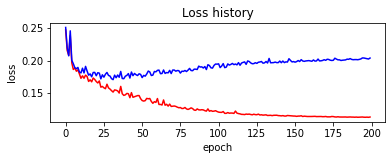

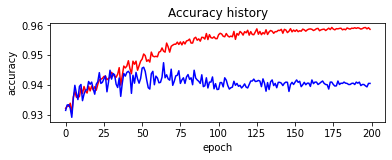

In [26]:
import matplotlib.pyplot as plt

plt.subplot(2,1,1)
# plt.plot(range(epoch+1), history['train_loss'], label='Loss', color='red')
# plt.plot(range(epoch+1), history['val_loss'], label='Loss', color='blue')
plt.plot(range(200), history['train_loss'][0:200], label='Loss', color='red')
plt.plot(range(200), history['val_loss'][0:200], label='Loss', color='blue')

plt.title('Loss history')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

plt.subplot(2,1,2)
plt.plot(range(200), history['train_acc'][0:200], label='Accuracy', color='red')
plt.plot(range(200), history['val_acc'][0:200], label='Accuracy', color='blue')

plt.title('Accuracy history')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [23]:
import csv
import os

os.chdir("C:\\Users\\widen\\Desktop\\predict_CAM\\MLP\\final")


# f = open('2_raw_base_labelled_all_set_predict_results.csv', 'r', encoding='utf-8')
f = open('final_2_raw_base_labelled_test_set_predict_results.csv', 'r', encoding='utf-8')
filereader = csv.reader(f)



temp_list = []

for line in filereader:
        temp_list.append(line)

f.close()

total = 0
vel_CAM_num = 0
acc = 0
acc_pm100ms = 0
velocity_wrong = 0
vel_CAM_correct = 0

for line in temp_list:
        if line[4] == '1' or line[6] == '1':
                vel_CAM_num += 1
                total += 1
                if line[9] == line[15]:
                        acc += 1
                        acc_pm100ms += 1
                        vel_CAM_correct += 1

                else:
                        velocity_wrong += 1
                        if (int(line[15]) + 1 == int(line[9])) or (int(line[15]) - 1 == int(line[9])):
                                acc_pm100ms += 1


        else:
                total += 1
                if line[9] == line[15]:
                        acc += 1
                        acc_pm100ms += 1



print("number of total CAM:", total)
print("number of velocity CAM:", vel_CAM_num)
print("percentage of velocity CAM:",  (vel_CAM_num/total)*100, "%\n")

print("accuracy for all CAM:", (acc/total)*100)
print("accuracy for velocity CAM:", (vel_CAM_correct/vel_CAM_num)*100, "\n")

print("accuracy of all CAM if plus minus 100ms for velocity CAM:", (acc_pm100ms/total)*100)
print("accuracy increased:", (acc_pm100ms/total)*100-(acc/total)*100, "%p\n")

print("number of velocity CAM correct:", vel_CAM_correct)
print("number of velocity CAM wrong:", velocity_wrong)
print("number of velocity CAM correct increased:", acc_pm100ms-acc, "\n")

print("accuracy of velocity CAM if plus minus 100ms: ", 100*(acc_pm100ms-acc+vel_CAM_correct)/vel_CAM_num)

number of total CAM: 2739
number of velocity CAM: 257
percentage of velocity CAM: 9.382986491420226 %

accuracy for all CAM: 94.88864549105513
accuracy for velocity CAM: 65.75875486381322 

accuracy of all CAM if plus minus 100ms for velocity CAM: 97.2252646951442
accuracy increased: 2.336619204089075 %p

number of velocity CAM correct: 169
number of velocity CAM wrong: 88
number of velocity CAM correct increased: 64 

accuracy of velocity CAM if plus minus 100ms:  90.6614785992218


In [24]:
import time

os.chdir("C:\\Users\\widen\\Desktop\\predict_CAM\\MLP\\final")
finalset = TrainDataset('2_raw_base_labelled_test_set.csv')
finalLoader = torch.utils.data.DataLoader(finalset, batch_size=1, shuffle = False)

In [25]:
start = time.time()
print_pred(model, finalLoader, device)
end = time.time()

print(f"{end - start:.10f} sec")
print(len(finalLoader))
print("Average Computation Time: ", (end-start)/len(finalLoader))

10.6150298119 sec
2739
Average Computation Time:  0.0038755128922450277


In [30]:
f = open('loss.csv','w', newline='')
wr = csv.writer(f)

wr.writerow(['train loss', 'validation loss'])

for i in range(200):
    wr.writerow([history['train_loss'][i], history['val_loss'][i]])
    
f.close()